<a href="https://colab.research.google.com/github/JulieOnIsland/Machine_Learning/blob/main/SkimLit_NLP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit Natural Language Processing Project

**Project Goals**

- Make the model predict which group (**background, objective, methods, results, or conclusions**) do the sentences in the abstract belong and classify them to each group in order to make the abstract more readable
- Reference the architecture of the model in the paper "Neural Networks for Joint Sentence Classification in Medical Paper Abstracts (Dernoncourt et al.2016)" 
- Build models and find the best one
- source: Zero To Mastery TensorFlow for Deep Learning course (by Daniel Bourke)


1. Downloading a text dataset
2. Writing a preprocessing function for our text data
3. Setting up multiple modelling experiments with different levels of embeddings
4. Building a multimodal model to take in different sources of data



**5 experiments**
```
Model 0: Naive Bayes (baseline)
Model 1: Conv1D with token embeddings
Model 2: Using pretrained embedding
Model 3: Conv1D with character embeddings
Model 4: Token embeddings + Character embeddings
Model 5: Token embeddings + Character embeddings + Positional embeddings
```

In [1]:
 !nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-2f5876ee-90bb-bd64-7d52-e9133b0baa3c)


In [2]:
# Get the data from author's GitHub
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


✋ Start with a smaller dataset and then upscale it

In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [5]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

# Preprocess the data

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
    """
    Reads filename and returns the lines of text as a list.
    """
    with open(filename, 'r') as f:
        return f.readlines()

In [7]:
# Read in the training lines
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:30]
# train_lines[-30:]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

Think about how we want our data to look...
- Daniel prefers dictionary

In [9]:
train_lines[0]

'###24293578\n'

In [10]:
train_lines[1]

'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n'

In [11]:
train_lines[1][:-1]

'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .'

In [12]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [13]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 932 ms, sys: 163 ms, total: 1.1 s
Wall time: 1.62 s


In [14]:
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [15]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [16]:
train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [17]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

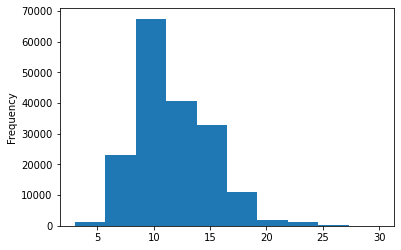

In [18]:
# length of different lines
train_df.total_lines.plot.hist();

In [19]:
# Convert abstract text lines into list
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

In [20]:
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [21]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

### One Hot encoding

In [22]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [23]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels

In [24]:
# Extract labels ('target' columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [25]:
# Check what training labels look like
train_labels_encoded[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

In [26]:
# Get class names and number of classes
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Model 0: Naive Bayes with TF-IDF encoder (baseline)

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
                    ('tf-idf', TfidfVectorizer()),   
                    ('clf', MultinomialNB())                # classifier
])

In [28]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [29]:
train_labels_encoded[:5]

array([3, 2, 2, 2, 2])

In [30]:
# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [31]:
# Evaluate the baseline model on validation dataset
baseline_score = model_0.score(val_sentences, val_labels_encoded)
print(f'The accuracy of the baseline model: {baseline_score * 100:.2f}%')

The accuracy of the baseline model: 72.18%


In [32]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4])

In [33]:
# Create an evaluation function
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall, and f1 score of a binary classification model
    """

    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall, and f1-score using weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    model_results = {'accuracy': model_accuracy,
                     'precision': model_precision,
                     'recall': model_recall,
                     'f1': model_f1}
    return model_results

In [34]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

# Model 1: Conv1D with token embeddings

In [35]:
# Create a tensorboard callback

import datetime
def create_tensorboard_callback(dir_name, experiment_name):
     log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
     tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

     print(f"Saving TensorBoard log files to: {log_dir}")
     return tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = 'model_logs'

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [37]:
train_df['text']

0         to investigate the efficacy of @ weeks of dail...
1         a total of @ patients with primary knee oa wer...
2         outcome measures included pain reduction and i...
3         pain was assessed using the visual analog pain...
4         secondary outcome measures included the wester...
                                ...                        
180035    for the absolute change in percent atheroma vo...
180036    for pav , a significantly greater percentage o...
180037    both strategies had acceptable side effect pro...
180038    compared with standard statin monotherapy , th...
180039    ( plaque regression with cholesterol absorptio...
Name: text, Length: 180040, dtype: object

In [38]:
train_sentences = train_df['text'].to_numpy()
train_sentences[:10]

array(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
       'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
       'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
       'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
       'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
       'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) we

In [39]:
val_sentences = val_df['text'].to_numpy()

## Tokenization

In [40]:
len(train_sentences[0].split(' '))

49

In [41]:
# My code
# total = 0
# for i in range(len(train_sentences)):
#     total += len(train_sentences[i].split(' '))

# avg_length = total / len(train_sentences)
# avg_length

In [42]:
# More simple code
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

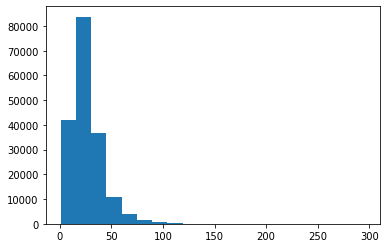

In [43]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [44]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [45]:
# Maximum sequence length in the training set
max(sent_lens)

296

In [46]:
# How many words are in our vocab? (taken from table 2 in the paper)
max_tokens = 68000

In [47]:
# Create text vectorizer layer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length= output_seq_len)

In [48]:
# Adapt text vectorizer to training setences (only training data)
text_vectorizer.adapt(train_sentences)

In [49]:
# Choose a random sentence from the training dataset and test out text vectorizer
import random

random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence}\
\n\n Vectorized version:{text_vectorizer([random_sentence])}')
print(f'Length of text: {len(random_sentence.split())}')

Original text:
 spmc groups reported superior palatability and tolerability compared to peg groups .

 Vectorized version:[[16525    24   205   496 12485     3   833    34     6  3234    24     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Length of text: 12


In [50]:
# How many words in our training vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'5 most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

Number of words in vocab: 64841
5 most common words: ['', '[UNK]', 'the', 'and', 'of']
5 least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [51]:
# Get the configuration of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

## Embedding

In [52]:
from tensorflow.keras import layers
token_embed = layers.Embedding(input_dim = len(words_in_vocab),
                             output_dim = 128,
                             mask_zero=True, 
                             input_length = output_seq_len,
                             name='token_embedding')

token_embed

In [53]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
vectorized_sentence = text_vectorizer([random_sentence])
embedded_sentence = token_embed(vectorized_sentence)

print(f'Original text:\n {random_sentence}\
\n\nVectorized Version:\n {vectorized_sentence}\
\n\nEmbedded Version:\n {embedded_sentence}')

Original text:
 a major flaw in the design of previous studies may have contributed to disappointing results : many subjects are not truly episodic in the nature of their headaches-they discount days with mild headache and ignore days with migraine-related neck pain .

Vectorized Version:
 [[    8   347 57670     5     2   372     4   468   202    91    99  3225
      6 20801   117   861   104    58    31 16409  6666     5     2  3403
      4   120 56454 23366    84     7   533  1309     3 20442    84     7
  14749   932    65     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Embedded Version:
 [[[ 0.03040047 -0.01928577 -0.04201557 ... -0.02110313 -0.01386892
    0.03025916]
  [-0.01128236  0.01984551  0.02566278 ...  0.04783435 -0.01969369
    0.00418321]
  [ 0.03968814 -0.03433587 -0.00354997 ...  0.03142658  0.00083171
   -0.01672532]
  ...
  [-0.02515749 -0.02326053 -0.01829026 ...  0.01683067 -0.00267211
   -0.04973736]
  [-0.025

In [54]:
embedded_sentence.shape

TensorShape([1, 55, 128])

## Create fast loading dataset

In [55]:
# Turn our data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [56]:
# Take the TensorSliceDataset and turn them into prefetched dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Build, compile, and fit the model

In [57]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5, 
                  activation='relu',
                  padding='same')(x)

x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1_Conv1D')

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['acc'])

# Get a summary
model_1.summary()

Model: "model_1_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)              

In [58]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),       # 10% of the batches
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_1_conv1d')])

Saving TensorBoard log files to: model_logs/model_1_conv1d/20220126-133025
Epoch 1/3
562/562 [==============================] - 26s 25ms/step - loss: 0.8334 - acc: 0.6832 - val_loss: 0.5801 - val_acc: 0.7882
Epoch 2/3
562/562 [==============================] - 13s 23ms/step - loss: 0.5792 - acc: 0.7883 - val_loss: 0.5391 - val_acc: 0.8059
Epoch 3/3
562/562 [==============================] - 11s 20ms/step - loss: 0.5433 - acc: 0.7970 - val_loss: 0.5180 - val_acc: 0.8125


In [59]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 7s 8ms/step - loss: 0.5214 - acc: 0.8054


[0.521361768245697, 0.805375337600708]

In [60]:
# Make predictions (prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
print(model_1_pred_probs)
print(model_1_pred_probs.shape)

[[5.97764015e-01 4.72194627e-02 1.28240639e-03 3.52361411e-01
  1.37273467e-03]
 [1.79614425e-01 7.55453587e-01 9.27525980e-04 6.04863912e-02
  3.51806707e-03]
 [1.87246189e-01 1.19148772e-02 2.99559976e-03 7.97260344e-01
  5.83039189e-04]
 ...
 [1.02222126e-04 1.36537373e-03 9.67884343e-03 8.27947079e-05
  9.88770843e-01]
 [8.10338557e-03 3.17198992e-01 3.50238569e-02 1.09915333e-02
  6.28682256e-01]
 [2.68002134e-02 9.56982613e-01 3.96501459e-03 3.14828916e-03
  9.10391379e-03]]
(30212, 5)


In [61]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [62]:
type(model_1_pred_probs[0])

numpy.ndarray

In [63]:
# Convert pred probs to classes

model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [64]:
# Calculate model 1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.53753475440223,
 'f1': 0.8035508761021711,
 'precision': 0.803324542671168,
 'recall': 0.8053753475440223}

In [65]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

# Model 2: Using Pretrained Feature Extractor (from TensorFlow Hub)

In [66]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [67]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random sentence:\n {random_train_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding:\n{use_embedded_sentence[0][:30]}')
print(f'Shape:\n{use_embedded_sentence.shape}')

Random sentence:
 at @-@ wk postpartum , @ swedish women with a self-reported pre-pregnancy bmi of @-@ kg/m ( @ ) were randomized to a @-wk behavior modification treatment with d , e , both or control using a @ factorial design .
Sentence after embedding:
[-3.3629529e-02  1.8429633e-02  9.0413843e-05 -4.5543175e-02
 -6.8206690e-02 -6.8644620e-03  3.8360644e-02 -1.8376865e-03
  5.0431326e-02  2.0270310e-02  5.6044005e-02 -4.8619490e-02
  3.5057701e-03 -1.5898811e-02 -5.5497218e-02 -6.4989575e-03
 -8.2450502e-02 -2.3968411e-03 -7.1276784e-02  6.8440445e-02
  4.8834603e-02  3.4122512e-02 -1.3516147e-02 -2.2924155e-02
  2.9217863e-02  4.3391973e-02 -6.0917631e-02  1.8357605e-02
 -4.8509855e-02 -1.8704785e-02]
Shape:
(1, 512)


In [68]:
# Create a keras layer 
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype='string',
                                        trainable=False,
                                        name='USE')

In [69]:
# Create model
model_2 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
], name='model_2_USE_feature_extractor')

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['acc'])

In [70]:
# Get a summary
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


## Build, compile, and fit the model

In [71]:
# Train a classifier on top of USE layer
model_2_history = model_2.fit(train_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps =int(0.1*len(valid_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_2_use_feature_extractor')])

Saving TensorBoard log files to: model_logs/model_2_use_feature_extractor/20220126-133200
Epoch 1/5
562/562 [==============================] - 28s 41ms/step - loss: 0.9150 - acc: 0.6446 - val_loss: 0.7964 - val_acc: 0.6892
Epoch 2/5
562/562 [==============================] - 17s 30ms/step - loss: 0.7678 - acc: 0.7017 - val_loss: 0.7545 - val_acc: 0.7051
Epoch 3/5
562/562 [==============================] - 13s 24ms/step - loss: 0.7524 - acc: 0.7122 - val_loss: 0.7392 - val_acc: 0.7161
Epoch 4/5
562/562 [==============================] - 20s 35ms/step - loss: 0.7205 - acc: 0.7243 - val_loss: 0.7123 - val_acc: 0.7274
Epoch 5/5
562/562 [==============================] - 22s 38ms/step - loss: 0.7287 - acc: 0.7204 - val_loss: 0.6940 - val_acc: 0.7307


In [72]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 33s 35ms/step - loss: 0.7011 - acc: 0.7334


[0.7010772228240967, 0.7333509922027588]

In [73]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs, model_2_pred_probs.shape

(array([[6.7206305e-01, 2.0491643e-01, 2.7684609e-03, 1.1120608e-01,
         9.0459436e-03],
        [5.0217605e-01, 3.9542222e-01, 5.5410150e-03, 9.4707765e-02,
         2.1529675e-03],
        [3.4409234e-01, 6.3198477e-02, 4.6286304e-02, 5.0493968e-01,
         4.1483246e-02],
        ...,
        [1.3604613e-03, 1.8311653e-03, 9.8595075e-02, 6.2806235e-04,
         8.9758521e-01],
        [2.8763048e-03, 2.6532849e-02, 4.8682448e-01, 1.0410706e-03,
         4.8272529e-01],
        [1.3278089e-01, 4.5137945e-01, 3.7453425e-01, 2.0725103e-03,
         3.9232858e-02]], dtype=float32), (30212, 5))

In [74]:
# I like number 8
model_2_pred_probs[8]

array([3.9824602e-04, 3.9014176e-03, 2.5950324e-02, 7.1998977e-04,
       9.6903002e-01], dtype=float32)

In [75]:
# Convert pred probs to classes

model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 2, 2, 2, 4, 1])>

In [76]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 73.33509863630346,
 'f1': 0.727776884974792,
 'precision': 0.7299112174673601,
 'recall': 0.7333509863630345}

## fine-tuning

In [77]:
# Create a keras layer 
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype='string',
                                        trainable=True,
                                        name='USE')

In [78]:
# Create model
model_2_tuning = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
], name='model_2_USE_tuning')

# Compile the model
model_2_tuning.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['acc'])

In [79]:
# Get a summary
model_2_tuning.summary()

Model: "model_2_USE_tuning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 256,864,133
Non-trainable params: 0
_________________________________________________________________


In [80]:
# Train a classifier on top of USE layer
model_2_tuning_history = model_2_tuning.fit(train_dataset,
                                            steps_per_epoch = int(0.1 * len(train_dataset)),
                                            epochs=5,
                                            validation_data=valid_dataset,
                                            validation_steps =int(0.1*len(valid_dataset)),
                                            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                                   'model_2_use_tuning')])

Saving TensorBoard log files to: model_logs/model_2_use_tuning/20220126-133547
Epoch 1/5
562/562 [==============================] - 160s 258ms/step - loss: 0.7465 - acc: 0.7102 - val_loss: 0.5570 - val_acc: 0.7892
Epoch 2/5
562/562 [==============================] - 133s 237ms/step - loss: 0.5577 - acc: 0.7935 - val_loss: 0.5213 - val_acc: 0.8002
Epoch 3/5
562/562 [==============================] - 135s 241ms/step - loss: 0.5262 - acc: 0.8035 - val_loss: 0.5008 - val_acc: 0.8125
Epoch 4/5
562/562 [==============================] - 133s 237ms/step - loss: 0.4988 - acc: 0.8177 - val_loss: 0.4796 - val_acc: 0.8201
Epoch 5/5
562/562 [==============================] - 135s 240ms/step - loss: 0.5007 - acc: 0.8169 - val_loss: 0.4769 - val_acc: 0.8238


In [81]:
# Evaluate on the whole validation dataset
model_2_tuning.evaluate(valid_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.4828 - acc: 0.8177


[0.4828155040740967, 0.817721426486969]

In [82]:
# Make predictions with fine tuning model
model_2_tuning_pred_probs = model_2_tuning.predict(valid_dataset)
model_2_tuning_pred_probs[:5], model_2_tuning_pred_probs.shape

(array([[7.0317310e-01, 1.4476603e-01, 3.9567784e-03, 1.4509471e-01,
         3.0093775e-03],
        [7.1055681e-01, 8.6541966e-02, 3.4641763e-03, 1.9771537e-01,
         1.7216675e-03],
        [2.6767322e-01, 3.2765334e-03, 7.2219400e-03, 7.2142720e-01,
         4.0121831e-04],
        [6.3562579e-03, 1.3555214e-03, 9.7147256e-01, 3.9675292e-03,
         1.6848182e-02],
        [6.1206520e-03, 6.3204831e-03, 9.3421197e-01, 2.8790396e-03,
         5.0467886e-02]], dtype=float32), (30212, 5))

In [83]:
# Convert pred probs to classes

model_2_tuning_preds = tf.argmax(model_2_tuning_pred_probs, axis=1)
model_2_tuning_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 3, 2, 2])>

In [84]:
# Calculate model 2 fine tuning results
model_2_tuning_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_tuning_preds)
model_2_tuning_results

{'accuracy': 81.77214351913148,
 'f1': 0.8189423942120189,
 'precision': 0.8318648791084693,
 'recall': 0.8177214351913147}

# Model 3: Conv1D with character embeddings

- Would this work? Is character embeddings efficient? 

## Tokenization

In [85]:
train_sentences[:5]

array(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
       'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
       'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
       'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
       'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .'],
      dtype=object)

In [86]:
# Make function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

# Text splitting not-character-level sequence into characters
split_chars(random_train_sentence)

'a t   @ - @   w k   p o s t p a r t u m   ,   @   s w e d i s h   w o m e n   w i t h   a   s e l f - r e p o r t e d   p r e - p r e g n a n c y   b m i   o f   @ - @   k g / m   (   @   )   w e r e   r a n d o m i z e d   t o   a   @ - w k   b e h a v i o r   m o d i f i c a t i o n   t r e a t m e n t   w i t h   d   ,   e   ,   b o t h   o r   c o n t r o l   u s i n g   a   @   f a c t o r i a l   d e s i g n   .'

In [87]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
# train_chars[:5]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [88]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

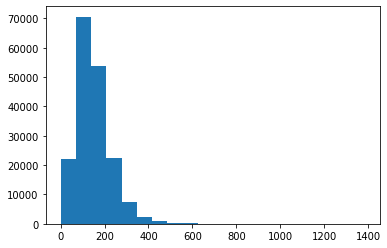

In [89]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=20);

In [90]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [91]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [92]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2   # add 2 for space and OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name='char_vectorizer')

In [93]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [94]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [95]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f'Text:{random_train_chars}')
print(f'Length of text: {len(random_train_chars)}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'Tokenized in character level:\n {vectorized_chars}')
print(f'Length of the tokenized: {len(vectorized_chars[0])}')

Text:d o c o s a h e x a e n o i c   a c i d   (   d h a   )   a c c u m u l a t e s   i n   t h e   h i p p o c a m p u s   a n d   f r o n t a l   l o b e s   o f   t h e   f e t a l   b r a i n   d u r i n g   t h e   l a s t   t r i m e s t e r   o f   p r e g n a n c y   .
Length of text: 273
Tokenized in character level:
 [[10  7 11  7  9  5 13  2 24  5  2  6  7  4 11  5 11  4 10 10 13  5  5 11
  11 16 15 16 12  5  3  2  9  4  6  3 13  2 13  4 14 14  7 11  5 15 14 16
   9  5  6 10 17  8  7  6  3  5 12 12  7 22  2  9  7 17  3 13  2 17  2  3
   5 12 22  8  5  4  6 10 16  8  4  6 18  3 13  2 12  5  9  3  3  8  4 15
   2  9  3  2  8  7 17 14  8  2 18  6  5  6 11 19  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0

## Character Embedding

In [96]:
# Create character embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,      # this value is from the paper
                              mask_zero=True,
                              name='character_embed')

In [97]:
# Test out character embedding layer
print(f'Charified text:\n {random_train_chars}\n')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded characters (after vectorization and embedding):\n {char_embed_example}\n')
print(f'Character embedding shaper: {char_embed_example.shape}')

Charified text:
 d o c o s a h e x a e n o i c   a c i d   (   d h a   )   a c c u m u l a t e s   i n   t h e   h i p p o c a m p u s   a n d   f r o n t a l   l o b e s   o f   t h e   f e t a l   b r a i n   d u r i n g   t h e   l a s t   t r i m e s t e r   o f   p r e g n a n c y   .

Embedded characters (after vectorization and embedding):
 [[[-0.03322987  0.04207477 -0.03404437 ... -0.00191031 -0.02987355
    0.00412315]
  [ 0.01831492 -0.03268724  0.03888209 ... -0.03410914  0.00157304
   -0.02290475]
  [ 0.0385547  -0.02529475  0.01989975 ... -0.02970802  0.01578471
    0.04244937]
  ...
  [-0.03722184 -0.04557863  0.04170433 ... -0.02802855  0.01605446
   -0.01428807]
  [-0.03722184 -0.04557863  0.04170433 ... -0.02802855  0.01605446
   -0.01428807]
  [-0.03722184 -0.04557863  0.04170433 ... -0.02802855  0.01605446
   -0.01428807]]]

Character embedding shaper: (1, 290, 25)


## Create fast loading dataset

In [98]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Build, compile, and fit the model

In [99]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_Conv1D_character_level')

# Compile the model
model_3.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['acc'])

# Get a summary
model_3.summary()

Model: "model_3_Conv1D_character_level"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 character_embed (Embedding)  (None, 290, 25)          700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 

In [100]:
# Fit the model
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_3_conv1d_character_level')])

Saving TensorBoard log files to: model_logs/model_3_conv1d_character_level/20220126-134822
Epoch 1/3
562/562 [==============================] - 7s 11ms/step - loss: 1.2571 - acc: 0.4877 - val_loss: 1.0333 - val_acc: 0.5868
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 0.9998 - acc: 0.6011 - val_loss: 0.9385 - val_acc: 0.6263
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.9187 - acc: 0.6413 - val_loss: 0.8729 - val_acc: 0.6513


In [101]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.18268082, 0.34669057, 0.17911024, 0.22051881, 0.07099959],
       [0.18137962, 0.48152816, 0.05388223, 0.13354701, 0.1496629 ],
       [0.12783954, 0.1467706 , 0.3171385 , 0.37942994, 0.02882144],
       ...,
       [0.01975279, 0.02376576, 0.20916457, 0.02455394, 0.72276294],
       [0.04554242, 0.14254643, 0.15661867, 0.05073545, 0.604557  ],
       [0.4230253 , 0.22841875, 0.09494568, 0.24761887, 0.00599145]],
      dtype=float32)

In [102]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [103]:
# Calculate results for Conv1d character level model 
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.44750430292598,
 'f1': 0.6440515632172202,
 'precision': 0.6473579910628917,
 'recall': 0.6544750430292599}

# Model 4: Pretrained token embeddings + character embeddings

- This model takes multiple different inputs

In [104]:
# 1. Setup token inputs/model
# Use Functional API instead of Sequential API
token_inputs = layers.Input(shape=[], dtype='string', name='token input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup character inputs/model
char_inputs = layers.Input(shape=(1,), dtype='string', name='char input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with car and token inputs
model_4 = tf.keras.Model(inputs=[token_model.inputs, char_model.inputs],
                         outputs=output_layer,
                         name='model_4_token_and_char_embeddings')

In [105]:
# Get a summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

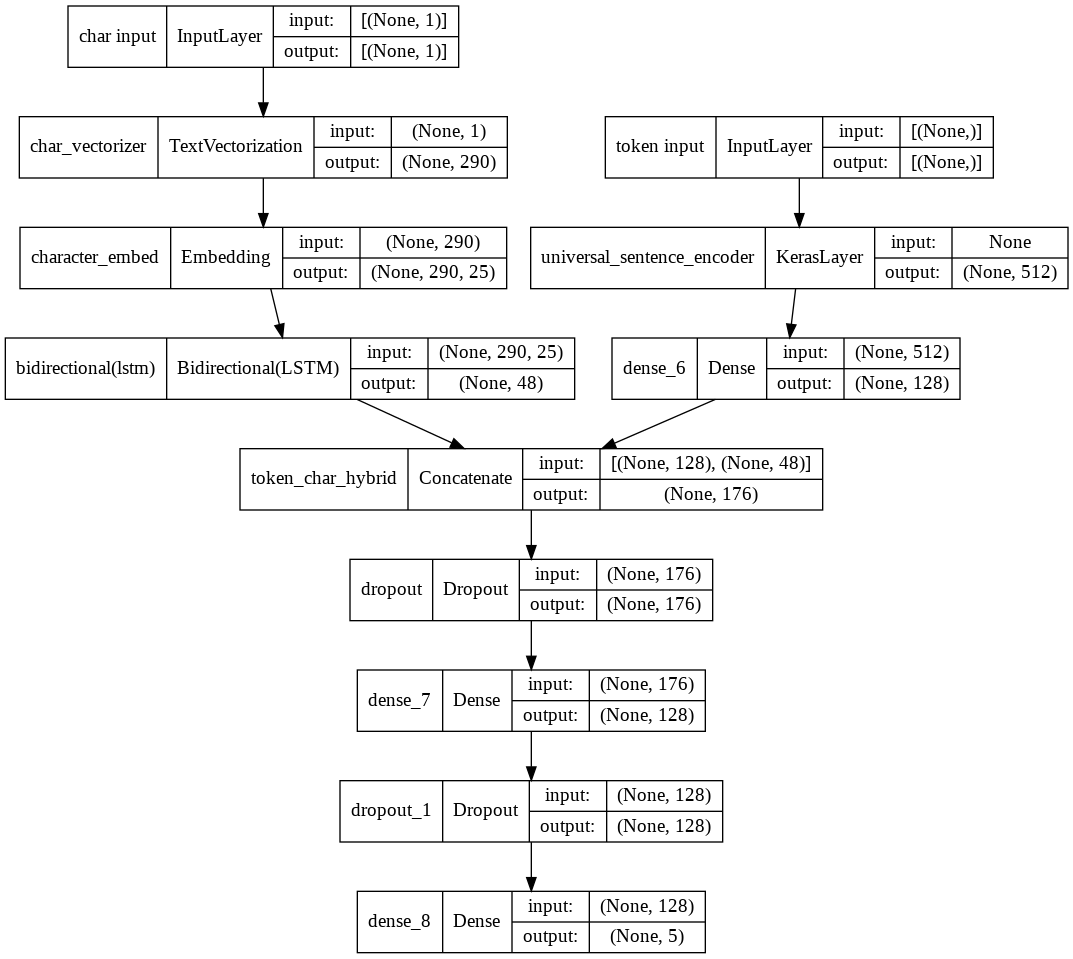

In [106]:
# Plot model 4 layers
tf.keras.utils.plot_model(model_4, show_shapes=True)

In [107]:
# Compile the model
model_4.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['acc'])

In [108]:
# Create fast loading dataset

# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))  # order should be same as model 4's input
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [109]:
# Check out the dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

In [110]:
# Fit the model
model_4_history = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),    
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_4_combined')])

Saving TensorBoard log files to: model_logs/model_4_combined/20220126-134848
Epoch 1/3
562/562 [==============================] - 91s 139ms/step - loss: 0.9798 - acc: 0.6106 - val_loss: 0.7865 - val_acc: 0.6975
Epoch 2/3
562/562 [==============================] - 75s 133ms/step - loss: 0.8014 - acc: 0.6900 - val_loss: 0.7181 - val_acc: 0.7264
Epoch 3/3
562/562 [==============================] - 71s 126ms/step - loss: 0.7790 - acc: 0.7020 - val_loss: 0.6945 - val_acc: 0.7357


In [111]:
# Evaluate on the whole validation dataset 
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 52s 55ms/step - loss: 0.7033 - acc: 0.7310


[0.7033284902572632, 0.7309678196907043]

In [112]:
# Make predictions
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.5669597e-01, 3.7065041e-01, 5.1665809e-03, 1.5753934e-01,
        9.9477367e-03],
       [4.0599006e-01, 3.2772473e-01, 5.0138766e-03, 2.5776610e-01,
        3.5052442e-03],
       [3.0547720e-01, 1.2218305e-01, 3.3007368e-02, 5.1553142e-01,
        2.3800990e-02],
       ...,
       [7.3182926e-04, 9.1892760e-03, 7.2623856e-02, 2.8191012e-04,
        9.1717315e-01],
       [1.1105002e-02, 6.8863384e-02, 1.9278815e-01, 4.1886605e-03,
        7.2305477e-01],
       [4.0401649e-01, 3.2304159e-01, 1.8430401e-01, 4.2655818e-02,
        4.5982100e-02]], dtype=float32)

In [113]:
# Format pred probs into labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 0])>

In [114]:
# Get results
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.09678273533694,
 'f1': 0.7290399817053772,
 'precision': 0.7328472988123415,
 'recall': 0.7309678273533695}

# Model 5: Pretrained token embeddings + character embeddings + positional embeddings

- Character Embeddings + Token Embeddings + Feature Embeddings

In [115]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


## Create positional embeddings

In [116]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

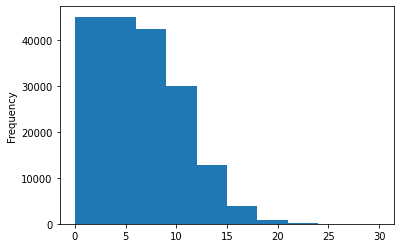

In [117]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist();

In [118]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:15], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [119]:
# How many different total length of lines are there?
total_line = train_df['total_lines'].value_counts()
total_line

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

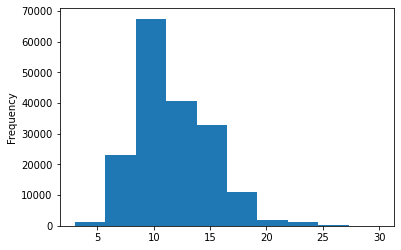

In [120]:
# Plot the distribution
train_df.total_lines.plot.hist();

In [121]:
# Check the coverage
np.percentile(train_df.total_lines, 95)
np.percentile(train_df.total_lines, 98)

20.0

In [122]:
# Create one-hot-encoded tensors of our total lines feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)
train_total_lines_one_hot[:15], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(15, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

## Build the model

In [123]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Character inputs
char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_numbers_inputs = layers.Input(shape=(15,), dtype='float32', name = 'line_numbers_inputs')
x = layers.Dense(32, activation='relu')(line_numbers_inputs)
line_numbers_model = tf.keras.Model(inputs = line_numbers_inputs,
                                    outputs = x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype='float32', name='total_lines_inputs')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                    outputs = y)

# 5. Combine the outputs of 1 & 2
combined_embeddings = layers.Concatenate(name='char_token_hybrid_embedding')([token_model.output,
                                                                              char_model.output])   # order is important
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)                                                                              

# 6. Combine the outputs of 3 & 4 & 5
tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_numbers_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_numbers_model.input,          # order
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name='model_5_tribrid_embedding')

In [124]:
# Get a summary
model_5.summary()

Model: "model_5_tribrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_i

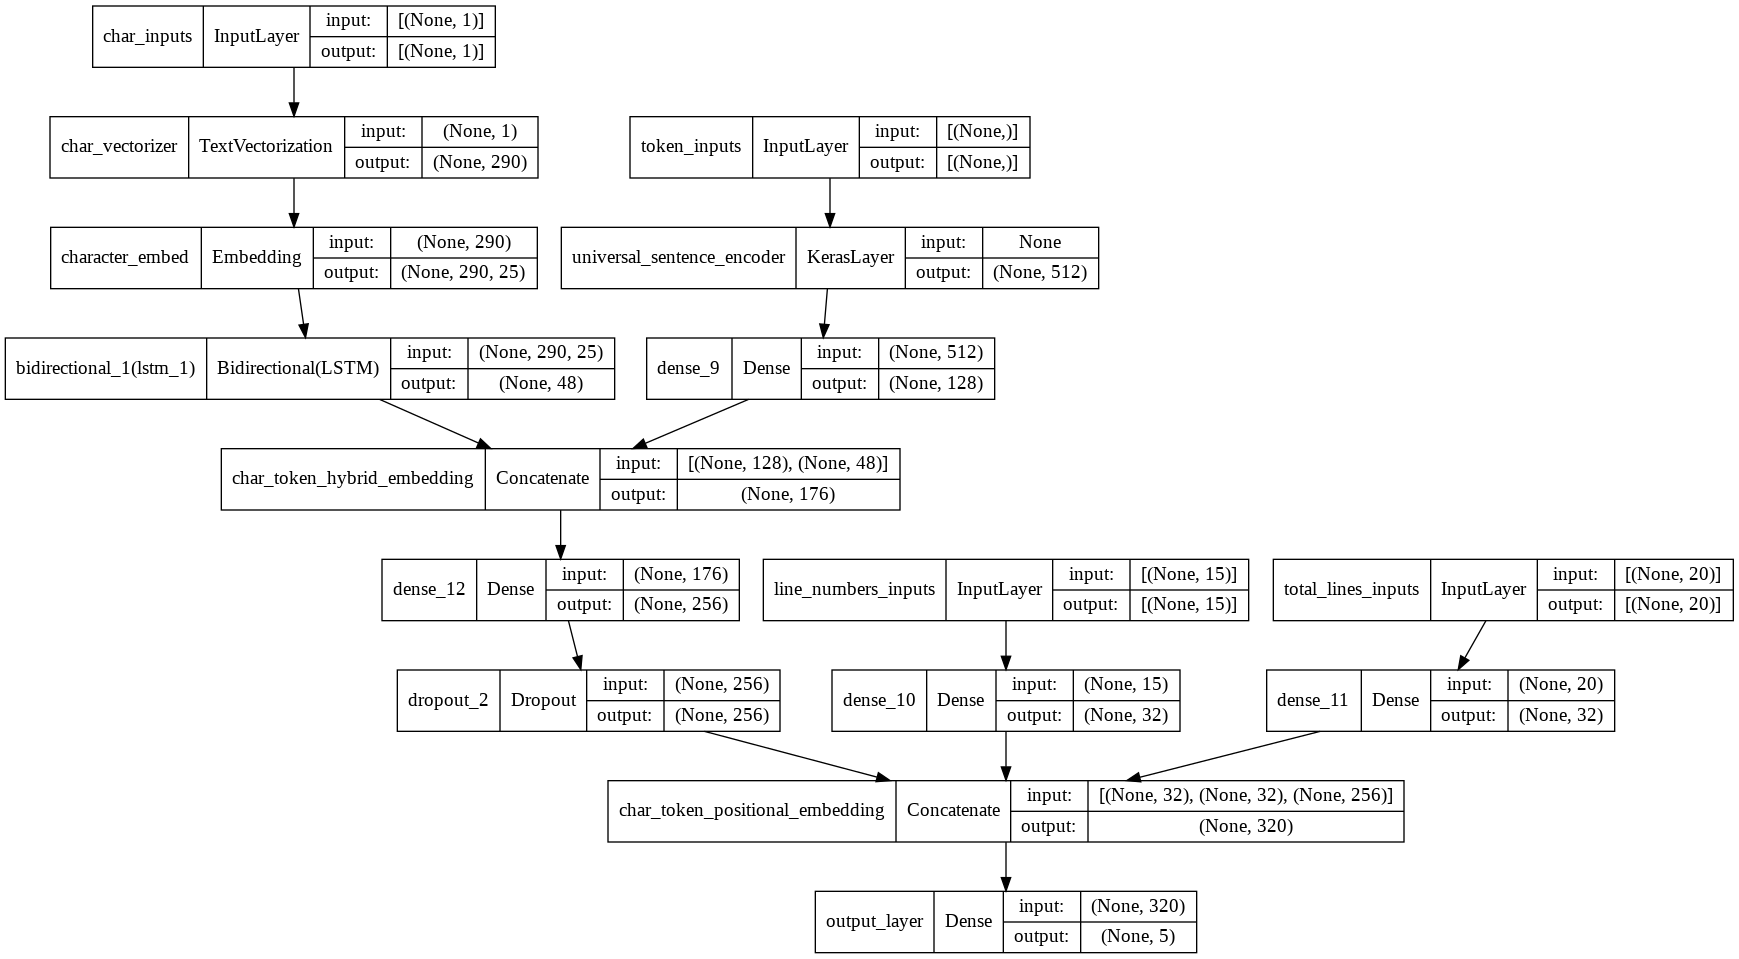

In [125]:
# Plot model_5
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [126]:
# Compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),     # label smoothing
                optimizer='Adam',
                metrics=['acc'])

## Create fast loading dataset

In [127]:
# training data
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,   # this order should be same as that of the model 5's input
                                                         train_total_lines_one_hot,
                                                         train_sentences, 
                                                         train_chars))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels))
train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# validation data
val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                       val_total_lines_one_hot,
                                                       val_sentences,
                                                       val_chars))
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels))
val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [128]:
# Check input shapes
train_tribrid_dataset, val_tribrid_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

## Fit the model, evaluate it, and make predictions

In [129]:
model_5_history = model_5.fit(train_tribrid_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_tribrid_dataset)),
                              validation_data=val_tribrid_dataset,
                              validation_steps=int(0.1 * len(val_tribrid_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_5_tribrid')])

Saving TensorBoard log files to: model_logs/model_5_tribrid/20220126-135537
Epoch 1/3
562/562 [==============================] - 90s 140ms/step - loss: 1.0952 - acc: 0.7219 - val_loss: 0.9839 - val_acc: 0.8025
Epoch 2/3
562/562 [==============================] - 77s 137ms/step - loss: 0.9675 - acc: 0.8159 - val_loss: 0.9502 - val_acc: 0.8248
Epoch 3/3
562/562 [==============================] - 70s 125ms/step - loss: 0.9510 - acc: 0.8225 - val_loss: 0.9390 - val_acc: 0.8301


In [130]:
# evaluate the model
model_5.evaluate(val_tribrid_dataset)

945/945 [==============================] - 52s 55ms/step - loss: 0.9363 - acc: 0.8340


[0.9362741112709045, 0.833973228931427]

In [131]:
# Make predictions
model_5_pred_probs = model_5.predict(val_tribrid_dataset)
model_5_pred_probs

array([[0.5145556 , 0.12144092, 0.00771252, 0.33943057, 0.01686041],
       [0.5407645 , 0.09865087, 0.03769631, 0.311851  , 0.01103729],
       [0.30700946, 0.11532035, 0.1261455 , 0.39318362, 0.05834103],
       ...,
       [0.03386373, 0.09770907, 0.04306327, 0.03011177, 0.7952522 ],
       [0.03039023, 0.27704608, 0.0987267 , 0.02729413, 0.5665428 ],
       [0.2687664 , 0.53016764, 0.08933026, 0.04797778, 0.06375789]],
      dtype=float32)

In [132]:
# Format pred probs into labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [133]:
# Get results
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.39732556600026,
 'f1': 0.8328359687474819,
 'precision': 0.8332500385471268,
 'recall': 0.8339732556600027}

## Visualize the results

In [143]:
val_df

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9
...,...,...,...,...
30207,RESULTS,pruritus occurred more frequently with the act...,9,13
30208,RESULTS,three patients in the active-regimen group ( @...,10,13
30209,RESULTS,hemoglobin values of grade @ ( @ to < @ g per ...,11,13
30210,CONCLUSIONS,rates of response to a @-week interferon-free ...,12,13


In [148]:
val_df['predicted target'] = [class_names[model_5_preds][i] for i in range(len(val_df))]

In [150]:
val_df.head(15)

,target,text,line_number,total_lines,predicted target
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9,BACKGROUND
1,BACKGROUND,it is not clear whether these patients would b...,1,9,BACKGROUND
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9,OBJECTIVE
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9,METHODS
4,METHODS,primary outcomes were improvement in quality o...,4,9,METHODS
5,RESULTS,sixty-five patients were randomized .,5,9,RESULTS
6,RESULTS,fifty-nine patients started treatment ( @ rece...,6,9,RESULTS
7,RESULTS,fifty-six patients took the full @ months of m...,7,9,RESULTS
8,RESULTS,"between the voriconazole and placebo groups , ...",8,9,RESULTS
9,CONCLUSIONS,we were unable to show a beneficial effect of ...,9,9,CONCLUSIONS


In [152]:
# Check out the wrong predictions
wrong_pred = val_df.loc[val_df['target'] != val_df['predicted target']]
wrong_pred.head()

,target,text,line_number,total_lines,predicted target
10,BACKGROUND,"opioid antagonists ( e.g. , naltrexone ) and p...",0,10,OBJECTIVE
12,BACKGROUND,combining naltrexone and alprazolam might safe...,2,10,OBJECTIVE
17,RESULTS,"pretreatment with naltrexone , alprazolam , an...",7,10,CONCLUSIONS
19,RESULTS,the combination attenuated a greater number of...,9,10,CONCLUSIONS
24,OBJECTIVE,we tested the impact of conceptual instruction...,3,10,METHODS


# Compare model results

In [135]:
# combine model results into a dataframe
all_model_results = pd.DataFrame({'model_0_tf_idf': baseline_results,
                                  'model_1_conv1d_token': model_1_results,
                                  'model_2_pretrained_feature_extraction': model_2_results,
                                  'model_2_fine_tuning': model_2_tuning_results,
                                  'model_3_conv1d_char': model_3_results,
                                  'model_4_hybrid_char_token': model_4_results,
                                  'model_5_tribrid_char_token_pos': model_5_results})

In [136]:
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_tf_idf,72.183238,0.718647,0.721832,0.698925
model_1_conv1d_token,80.537535,0.803325,0.805375,0.803551
model_2_pretrained_feature_extraction,73.335099,0.729911,0.733351,0.727777
model_2_fine_tuning,81.772144,0.831865,0.817721,0.818942
model_3_conv1d_char,65.447504,0.647358,0.654475,0.644052
model_4_hybrid_char_token,73.096783,0.732847,0.730968,0.729040
model_5_tribrid_char_token_pos,83.397326,0.833250,0.833973,0.832836


In [137]:
# Reduce the accuracy to same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy'] / 100

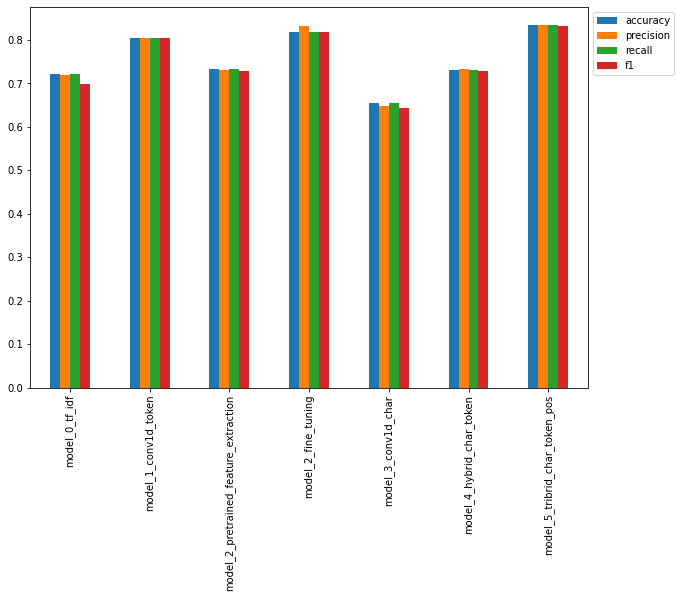

In [140]:
# Plot and compare all model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

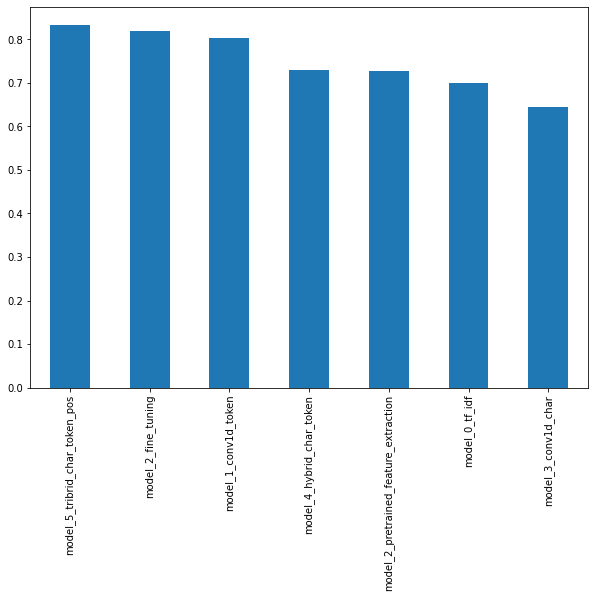

In [141]:
# Sort models results by f1-score
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7));

✋Model 5 showed 83% accuracy. Amazing!
